# ALOHAdielCurveFit: A Jupyter Notebook to fit sinusoidal functions to some of the SCOPE diel data 
Created 12 Apr 2018 by Jamie Collins, james.r.collins@aya.yale.edu
Revision history in GitHub

Some of this code inspired by MATLAB scripts developed for Modeling, Data Analysis and Numerical Techniques for Geochemistry (12.747), a course at MIT

Dependencies: scipy.optimize, numpy, some others

## First, load necessary libraries; let user set working directory

In [1]:
# load libraries
import numpy as np
import csv
import os
import pandas
from datetime import *
import pytz
import pytz_convert
import time
from datetime import timedelta
import iso8601 # so awesome this exists in python; you may need to install it 
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
from scipy.optimize import curve_fit

# user set working directory
os.chdir('/Users/jamesrco/Code/DielALOHA/')
print("Working in:",os.getcwd())

Working in: /Users/jamesrco/Code/DielALOHA


## A test

In [2]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

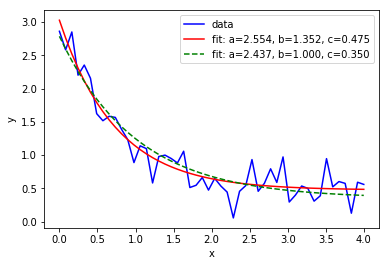

Parameter fits of optimized model:


array([2.43708905, 1.        , 0.35015434])

R-squared of fit:


0.8957084790510728

Parameter uncertainties (1 sigma):


array([0.12336385, 0.12952817, 0.07844143])

In [3]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(1729)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

popt, pcov = curve_fit(func, xdata, ydata)
popt
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 1., 0.5]))
popt
plt.plot(xdata, func(xdata, *popt), 'g--',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

print("Parameter fits of optimized model:")
display(popt)
print("R-squared of fit:")
residuals = ydata - func(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
display(r_squared)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr = np.sqrt(np.diag(pcov))
display(perr)


## The real deal

### Load data, take a peek

In [4]:
dielSulfonates_raw = pandas.read_csv('data/sulfonates/sulfonates_BD.csv')
dielSeaFlow_raw = pandas.read_csv('data/seaflow/seaflow_biomassDIEL_jorJamie.csv')

display(dielSulfonates_raw.head(n=10))
display(dielSeaFlow_raw.head(n=10))

,Station,time,Replicate,Timestamp_bottle_closure_GMT_ISO8601,Cysteic_Acid_pmol.L,Cysteinolic_acid_PA.L,DHPS_pmol.L,Isethionic_Acid_pmol.L,Sulfolactic_Acid_pmol.L,Taurine_pmol.L
0,6,700,1,2015-07-26T17:11:00-0000,4.421507,6.949541e+05,56.947953,3.571307,2.645641,19.067415
1,6,700,2,2015-07-26T17:11:00-0000,0.493252,2.043138e+06,528.974628,14.574636,3.587629,54.789920
2,6,700,3,2015-07-26T17:11:00-0000,3.071356,1.707758e+06,432.111451,10.481211,6.450681,42.902283
3,7,1000,1,2015-07-26T20:25:00-0000,7.601564,3.198881e+06,315.924313,12.603545,4.005653,209.026833
4,7,1000,2,2015-07-26T20:25:00-0000,4.291812,5.744861e+06,771.503512,31.420815,3.718890,65.651715
5,7,1000,3,2015-07-26T20:25:00-0000,0.592208,4.729765e+06,1527.930893,19.561125,6.248778,51.148806
6,8,1400,1,2015-07-27T00:29:00-0000,7.195938,5.410413e+06,1761.605319,33.739859,4.320685,71.730329
7,8,1400,2,2015-07-27T00:29:00-0000,0.466945,1.021502e+07,5043.952082,55.227529,12.421041,94.619387
8,8,1400,3,2015-07-27T00:29:00-0000,6.103194,4.964977e+06,666.905509,45.784641,2.872352,114.770626
9,11,1800,1,2015-07-27T04:27:00-0000,2.901025,7.968625e+06,2311.339370,49.955310,2.753558,135.176525


,Timestamp_ISO8601,Sum of abundance_cell.uL,Sum of Qc_pg.cell,Sum of Cbiomass_ug.L,Cbiomass_umol.L
0,2015-07-25T07:01:00-10:00,0.976418,14.029181,13.698349,1.140512
1,2015-07-25T07:04:00-10:00,1.036827,10.866547,11.266727,0.938057
2,2015-07-25T07:07:00-10:00,1.207168,10.731003,12.954125,1.078549
3,2015-07-25T07:10:00-10:00,1.088433,10.819991,11.776836,0.980529
4,2015-07-25T07:13:00-10:00,1.015561,9.844304,9.997491,0.832382
5,2015-07-25T07:16:00-10:00,1.181247,10.650057,12.580345,1.047428
6,2015-07-25T07:19:00-10:00,1.070121,10.080352,10.787198,0.898132
7,2015-07-25T07:22:00-10:00,0.976476,10.383692,10.139423,0.844199
8,2015-07-25T07:25:00-10:00,1.123217,9.155938,10.284105,0.856245
9,2015-07-25T07:28:00-10:00,1.038736,9.513941,9.882473,0.822806


### Do some data cleaning

In [5]:
dielSulfonates = dielSulfonates_raw.copy()
dielSeaFlow = dielSeaFlow_raw.copy()

# parse and convert dates, ensure all in HST, then store
dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'] = (
    dielSulfonates_raw['Timestamp_bottle_closure_GMT_ISO8601'].apply(iso8601.parse_date))
dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'] = (
    dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'].apply(
        lambda x: datetime.astimezone(x, pytz.timezone('Pacific/Honolulu'))))

dielSeaFlow['Timestamp_ISO8601'] = (
    dielSeaFlow_raw['Timestamp_ISO8601'].apply(iso8601.parse_date))
dielSeaFlow['Timestamp_ISO8601'] = (
    dielSeaFlow['Timestamp_ISO8601'].apply(
        lambda x: datetime.astimezone(x, pytz.timezone('Pacific/Honolulu'))))

# take a look again at new objects
display(dielSeaFlow.head(n=3))
display(dielSulfonates.head(n=3))

,Timestamp_ISO8601,Sum of abundance_cell.uL,Sum of Qc_pg.cell,Sum of Cbiomass_ug.L,Cbiomass_umol.L
0,2015-07-25 07:01:00-10:00,0.976418,14.029181,13.698349,1.140512
1,2015-07-25 07:04:00-10:00,1.036827,10.866547,11.266727,0.938057
2,2015-07-25 07:07:00-10:00,1.207168,10.731003,12.954125,1.078549


,Station,time,Replicate,Timestamp_bottle_closure_GMT_ISO8601,Cysteic_Acid_pmol.L,Cysteinolic_acid_PA.L,DHPS_pmol.L,Isethionic_Acid_pmol.L,Sulfolactic_Acid_pmol.L,Taurine_pmol.L
0,6,700,1,2015-07-26 07:11:00-10:00,4.421507,6.949541e+05,56.947953,3.571307,2.645641,19.067415
1,6,700,2,2015-07-26 07:11:00-10:00,0.493252,2.043138e+06,528.974628,14.574636,3.587629,54.789920
2,6,700,3,2015-07-26 07:11:00-10:00,3.071356,1.707758e+06,432.111451,10.481211,6.450681,42.902283


### Analysis
#### Sulfonate data: DHPS

First, let's take a look at a quick plot

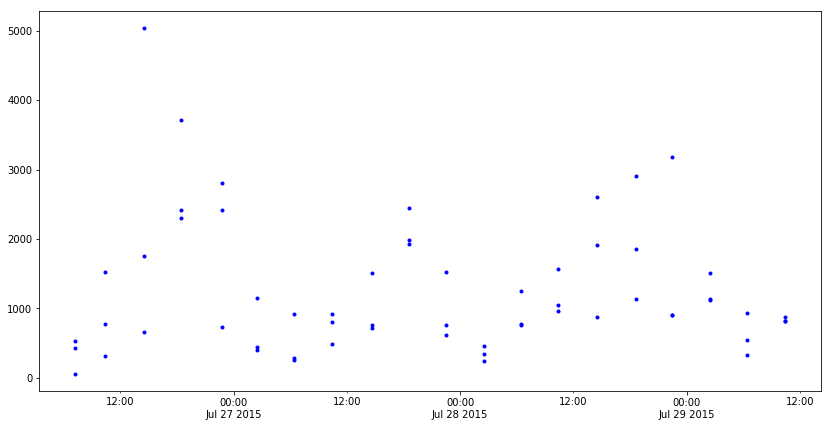

In [6]:
# after much searching, seems like easiest way to get the time ticks in these plots to come out right is to
# change matplotlib's base timezone for the time being
# probably a bad idea since, so we'll make sure to restore current setting after plotting

# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'],dielSulfonates['DHPS_pmol.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

#ax2 = ax1.twinx()
#ax2.plot(dielSeaFlow['Timestamp_ISO8601'],dielSeaFlow['Cbiomass_umol.L'], 'r-')

#ax2.set_ylim(0.4, 1.8)

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

Before curve fitting, have to excise some NaNs and convert the timestamp field to a different data type

In [7]:
# remove NaNs
TimestampDHPS_noNan = dielSulfonates['Timestamp_bottle_closure_GMT_ISO8601'][~np.isnan(dielSulfonates['DHPS_pmol.L'])]
ConcDHPS_noNan = dielSulfonates['DHPS_pmol.L'][~np.isnan(dielSulfonates['DHPS_pmol.L'])]

# convert time object
print("Starting as:",type(TimestampDHPS_noNan[0]),",",TimestampDHPS_noNan.dtypes)
display(TimestampDHPS_noNan.head(n=3))

TimestampDHPS_secFromStart = TimestampDHPS_noNan-TimestampDHPS_noNan[0]

print("After converting:",type(TimestampDHPS_secFromStart[0]),",",TimestampDHPS_secFromStart.dtypes)
display(TimestampDHPS_secFromStart.head(n=20))

TimestampDHPS_secFromStart_alt = (
    TimestampDHPS_secFromStart.apply(
        lambda x: x.total_seconds()))

print("Or maybe just as second increments:")
display(TimestampDHPS_secFromStart_alt.head(n=20))

Starting as: <class 'pandas._libs.tslib.Timestamp'> , datetime64[ns, Pacific/Honolulu]


0   2015-07-26 07:11:00-10:00
1   2015-07-26 07:11:00-10:00
2   2015-07-26 07:11:00-10:00
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: datetime64[ns, Pacific/Honolulu]

After converting: <class 'pandas._libs.tslib.Timedelta'> , timedelta64[ns]


0    00:00:00
1    00:00:00
2    00:00:00
3    03:14:00
4    03:14:00
5    03:14:00
6    07:18:00
7    07:18:00
8    07:18:00
9    11:16:00
10   11:16:00
11   11:16:00
12   15:35:00
13   15:35:00
14   15:35:00
15   19:16:00
16   19:16:00
17   19:16:00
18   23:15:00
19   23:15:00
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: timedelta64[ns]

Or maybe just as second increments:


0         0.0
1         0.0
2         0.0
3     11640.0
4     11640.0
5     11640.0
6     26280.0
7     26280.0
8     26280.0
9     40560.0
10    40560.0
11    40560.0
12    56100.0
13    56100.0
14    56100.0
15    69360.0
16    69360.0
17    69360.0
18    83700.0
19    83700.0
Name: Timestamp_bottle_closure_GMT_ISO8601, dtype: float64

Actually do the fitting

In [8]:
# define our function, assuming data is sinusoidal over three periods

# function where period is kept constant
def multWaves_func_samePer_3(x, a, b, c, d, e, f, g, h, i):
    return a * (np.sin(2 * np.pi / b * x + c )) + (
        d * (np.sin(2 * np.pi / b * x + e ))) + (
        f * (np.sin(2 * np.pi / b * x + g ))) + h + i * x
# a, d, f: amplitudes
# b: period
# c, e, g: phase
# h: y-offset
# i: slope of linear trend (if any)

# function where period is allowed to vary
def multWaves_func_varPer_3(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * np.sin(2 * np.pi / b * x + c ) + (
        d * np.sin(2 * np.pi / e * x + f )) + (
        g * np.sin(2 * np.pi / h * x + i )) + j + k * x
# a, d, g: amplitudes
# b, e, h: period
# c, f, i: phase
# j: y-offset
# k: slope of linear trend (if any)


# do the fitting
popt_samePer, pcov_samePer = curve_fit(multWaves_func_samePer_3, TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, bounds=(
    [-100000, 50000, -100000, -100000, -100000, -100000, -100000, -100000, -100000], (
        [15000, 100000, 15000, 15000, 15000, 15000, 15000, 15000, 15000])))
popt_varPer, pcov_varPer = curve_fit(multWaves_func_varPer_3, TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, bounds=(
    [-100000, 0, -100000, -100000, 0, -100000, -100000, 0, -100000, -100000, -100000], (
        [15000, 100000, 15000, 15000, 100000, 15000, 15000, 100000, 15000, 15000, 15000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd value) is kept constant:")
display(popt_samePer)
print("R-squared of fit:")
residuals_samePer = ConcDHPS_noNan - multWaves_func_samePer_3(TimestampDHPS_secFromStart_alt, *popt_samePer)
ss_res_samePer = np.sum(residuals_samePer**2)
ss_tot_samePer = np.sum((ConcDHPS_noNan-np.mean(ConcDHPS_noNan))**2)
r_squared_samePer = 1 - (ss_res_samePer / ss_tot_samePer)
display(r_squared_samePer)
# calculate the uncertainties in our coefficients
print("Parameter uncertainties (1 sigma):")
perr_samePer = np.sqrt(np.diag(pcov_samePer))
display(perr_samePer)

print("Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:")
display(popt_varPer)
print("R-squared of fit:")
residuals_varPer = ConcDHPS_noNan - multWaves_func_varPer_3(TimestampDHPS_secFromStart_alt, *popt_varPer)
ss_res_varPer = np.sum(residuals_varPer**2)
ss_tot_varPer = np.sum((ConcDHPS_noNan-np.mean(ConcDHPS_noNan))**2)
r_squared_varPer = 1 - (ss_res_varPer / ss_tot_varPer)
display(r_squared_varPer)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer = np.sqrt(np.diag(pcov_varPer))
display(perr_varPer)


Parameter fits for model where length of period (2nd value) is kept constant:


array([-3.28878451e+04,  8.66481888e+04, -4.01951331e+04, -3.28892616e+04,
       -4.01972324e+04, -3.29068063e+04, -4.00485031e+04,  1.36253384e+03,
       -3.53977513e-04])

R-squared of fit:


0.38832105784934234

Parameter uncertainties (1 sigma):


array([2.86233378e+10, 2.79576510e+03, 2.20513903e+10, 2.68322924e+10,
       2.14322571e+10, 3.44693319e+10, 2.16439479e+10, 2.23047222e+02,
       1.42331450e-03])

Parameter fits for model where length of period (2nd, 5th, 8th values) is allowed to vary:


array([-2.82832777e+04,  8.13089800e+04, -4.12574390e+04, -2.83394347e+04,
        8.15355657e+04, -4.12929985e+04, -2.84512626e+04,  8.14186601e+04,
       -4.12720940e+04,  1.47417631e+03, -1.12158778e-03])

R-squared of fit:


0.4397502392520357

Parameter uncertainties (1 sigma):


array([1.01118992e+09, 2.45434498e+06, 1.39079543e+04, 6.44728143e+08,
       1.67486799e+06, 1.15595363e+04, 7.40800413e+08, 2.75021671e+06,
       4.62147514e+04, 2.33375483e+02, 1.39123905e-03])

Now, let's take a look at a plot of the data, with the curve fit (varying period length allowed)

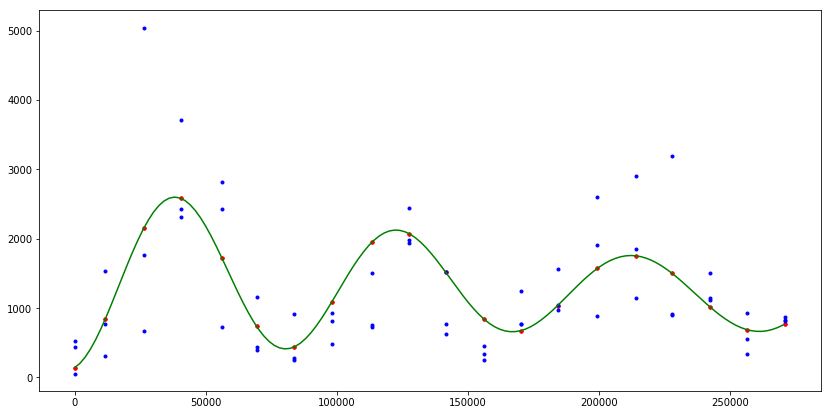

In [10]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampDHPS_secFromStart_alt, multWaves_func_varPer_3(TimestampDHPS_secFromStart_alt, *popt_varPer), 'r.')
plt.plot(TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_varPer), 'g-')

A plot of the data, with the curve fit (length of period required to be constant)

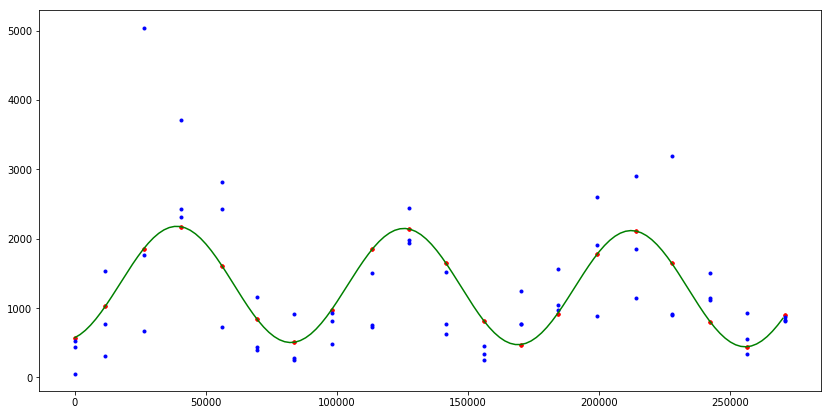

In [12]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampDHPS_secFromStart_alt, multWaves_func_samePer_3(TimestampDHPS_secFromStart_alt, *popt_samePer), 'r.')
plt.plot(TimestampDHPS_secFromStart_alt, ConcDHPS_noNan, 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_samePer), 'g-')

Look at the two together

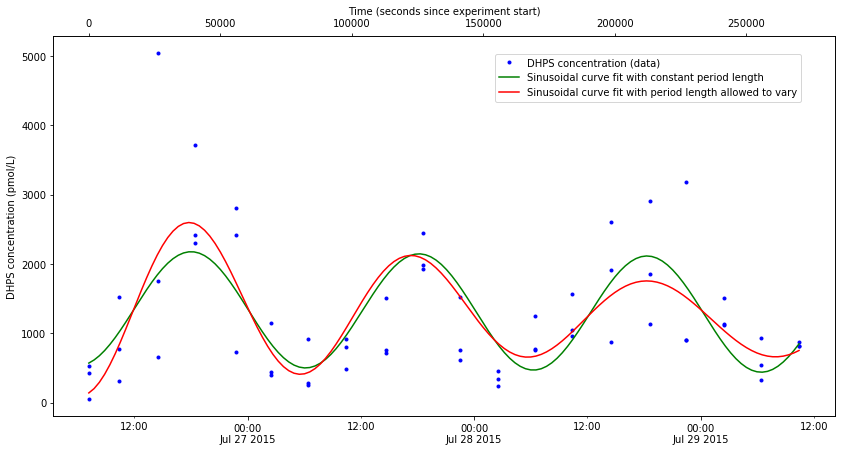

In [13]:
# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(TimestampDHPS_noNan,ConcDHPS_noNan, 'b.', label = 'DHPS concentration (data)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('DHPS concentration (pmol/L)')

ax2 = ax1.twiny()
ax2.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_samePer), 'g-', label = 'Sinusoidal curve fit with constant period length')
ax2.plot(pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_3(
   pandas.Series(list(range(0, int(TimestampDHPS_secFromStart_alt[len(TimestampDHPS_secFromStart_alt)-1]), 2000))), *popt_varPer), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ


#### Seaflow data

We'll truncate the data so the time domain (at least lower bound) is the same as the sulfur compound concentration data

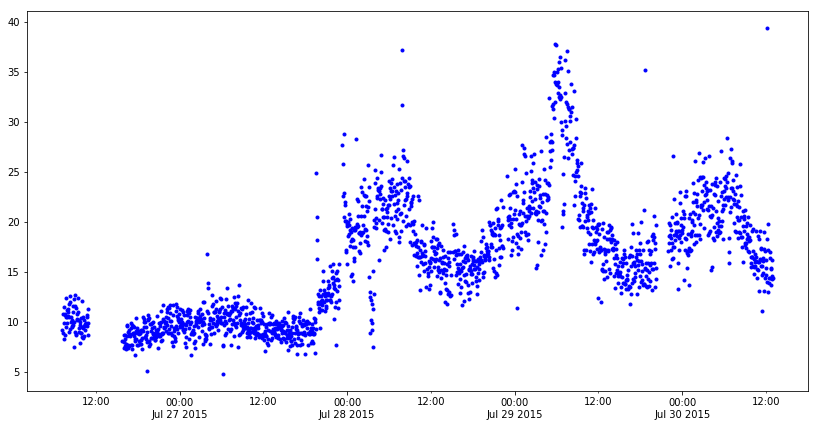

In [15]:
# truncate data to same datetime range as the sulfur compound concentrations
dielSeaFlow.trunc = dielSeaFlow[dielSeaFlow['Timestamp_ISO8601']>=min(TimestampDHPS_noNan)]
#dielSeaFlow.trunc = dielSeaFlow.trunc[dielSeaFlow.trunc['Timestamp_ISO8601']<=max(TimestampDHPS_noNan)]

# quick look at a plot
# get, store current setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 
        
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSeaFlow.trunc['Timestamp_ISO8601'],dielSeaFlow.trunc['Sum of Cbiomass_ug.L'], 'b.')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ

It's evident that the phase of the Seaflow data isn't the same as the sulfur compound data. We'll still try to fit s curve to it.

In [16]:
# convert time object
print("Starting as:",type(dielSeaFlow.trunc['Timestamp_ISO8601'][0]),",",dielSeaFlow.trunc['Timestamp_ISO8601'].dtypes)
display(dielSeaFlow.trunc['Timestamp_ISO8601'].head(n=3))

TimestampSeaflow_secFromStart = dielSeaFlow.trunc['Timestamp_ISO8601']-dielSeaFlow.trunc['Timestamp_ISO8601'][0]
TimestampSeaflow_secFromStart_alt = (
    TimestampSeaflow_secFromStart.apply(
        lambda x: x.total_seconds()))

print("As second increments:")
display(TimestampSeaflow_secFromStart_alt.head(n=20))

Starting as: <class 'pandas._libs.tslib.Timestamp'> , datetime64[ns, Pacific/Honolulu]


465   2015-07-26 07:13:00-10:00
466   2015-07-26 07:16:00-10:00
467   2015-07-26 07:19:00-10:00
Name: Timestamp_ISO8601, dtype: datetime64[ns, Pacific/Honolulu]

As second increments:


465       0.0
466     180.0
467     360.0
468     540.0
469     720.0
470     900.0
471    1080.0
472    1260.0
473    1440.0
474    1620.0
475    1800.0
476    1980.0
477    2160.0
478    2340.0
479    2520.0
480    2700.0
481    2880.0
482    3060.0
483    3240.0
484    3420.0
Name: Timestamp_ISO8601, dtype: float64

Do the fitting for the Seaflow data; will use four periods instead of three

In [17]:
# define our function, assuming data is sinusoidal over four periods

# function where period is kept constant
def multWaves_func_samePer_4(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * (np.sin(2 * np.pi / b * x + c )) + (
        d * (np.sin(2 * np.pi / b * x + e ))) + (
        f * (np.sin(2 * np.pi / b * x + g ))) + (
        h * (np.sin(2 * np.pi / b * x + i ))) + j + k * x
# a, d, f, h: amplitudes
# b: period
# c, e, g, i: phase
# j: y-offset
# k: slope of linear trend (if any)

# do the fitting
popt_samePer, pcov_samePer = curve_fit(multWaves_func_samePer_4, TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Sum of Cbiomass_ug.L'], bounds=(
    [-100000, 50000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000, -100000], (
        [150000, 100000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 150000, 15000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd value) is kept constant:")
display(popt_samePer)
print("R-squared of fit:")
residuals_samePer = dielSeaFlow.trunc['Sum of Cbiomass_ug.L'] - multWaves_func_samePer_4(TimestampSeaflow_secFromStart_alt, *popt_samePer)
ss_res_samePer = np.sum(residuals_samePer**2)
ss_tot_samePer = np.sum((dielSeaFlow.trunc['Sum of Cbiomass_ug.L']-np.mean(dielSeaFlow.trunc['Sum of Cbiomass_ug.L']))**2)
r_squared_samePer = 1 - (ss_res_samePer / ss_tot_samePer)
display(r_squared_samePer)
# calculate the uncertainties in our coefficients
print("Parameter uncertainties (1 sigma):")
perr_samePer = np.sqrt(np.diag(pcov_samePer))
display(perr_samePer)

Parameter fits for model where length of period (2nd value) is kept constant:


array([-1.38710826e+04,  8.57527196e+04,  1.70256470e+04, -1.38410439e+04,
        1.74773062e+04, -1.34103258e+04,  1.73799565e+04, -1.38600112e+04,
        1.71544023e+04,  8.82423572e+00,  3.71037331e-05])

R-squared of fit:


0.5782487556406644

Parameter uncertainties (1 sigma):


array([1.53539542e-04, 4.42854741e+02, 2.25898216e-04, 5.72428537e-04,
       2.52152658e-04, 2.26309076e-04, 2.33735035e-04, 8.47779075e-05,
       2.52089504e-04, 1.92442061e-01, 9.09602974e-07])

Now, let's take a look at a plot of the data, with the curve fit (period length fixed)

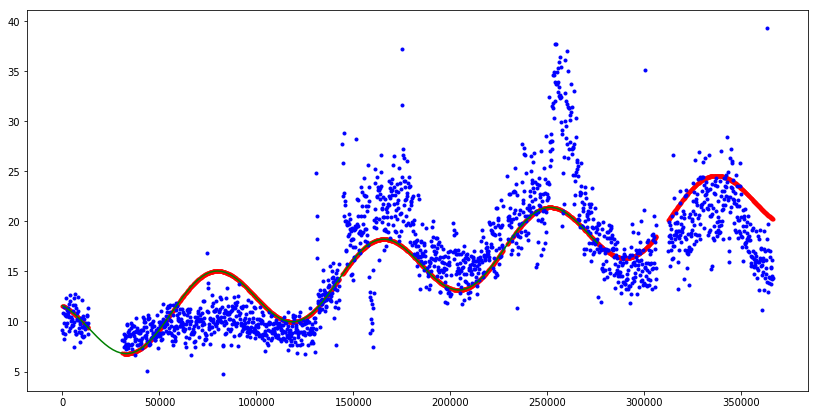

In [18]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampSeaflow_secFromStart_alt, multWaves_func_samePer_4(TimestampSeaflow_secFromStart_alt, *popt_samePer), 'r.')
plt.plot(TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Sum of Cbiomass_ug.L'], 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_4(
   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_samePer), 'g-')

In [19]:
# function where period is allowed to vary
def multWaves_func_varPer_4(x, a, b, c, d, e, f, g, h, i, j, k, l, m, n):
    return a * np.sin(2 * np.pi / b * x + c ) + (
        d * np.sin(2 * np.pi / e * x + f )) + (
        g * np.sin(2 * np.pi / h * x + i )) + (
        j * np.sin(2 * np.pi / k * x + l )) + m + n * x
# a, d, g, j: amplitudes
# b, e, h, k: period
# c, f, i, l: phase
# m: y-offset
# n: slope of linear trend (if any)

# do the fitting
popt_varPer, pcov_varPer = curve_fit(multWaves_func_varPer_4, TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Cbiomass_umol.L'], bounds=(
    [-1000000, 50000, -1000000, -1000000, 95000, -1000000, -1000000, 50000, -1000000, -1000000, 50000, -1000000, -1000000, -1000000], (
        [200000, 1500000, 200000, 200000, 150000, 200000, 200000, 150000, 200000, 200000, 150000, 200000, 200000, 200000])))

# output results, and some diagnostics
print("Parameter fits for model where length of period (2nd, 5th, 8th, 11th values) is allowed to vary:")
display(popt_varPer)
print("R-squared of fit:")
residuals_varPer = dielSeaFlow.trunc['Cbiomass_umol.L'] - multWaves_func_varPer_4(TimestampSeaflow_secFromStart_alt, *popt_varPer)
ss_res_varPer = np.sum(residuals_varPer**2)
ss_tot_varPer = np.sum((dielSeaFlow.trunc['Cbiomass_umol.L']-np.mean(dielSeaFlow.trunc['Cbiomass_umol.L']))**2)
r_squared_varPer = 1 - (ss_res_varPer / ss_tot_varPer)
display(r_squared_varPer)
# calculate the uncertainties
print("Parameter uncertainties (1 sigma):")
perr_varPer = np.sqrt(np.diag(pcov_varPer))
display(perr_varPer)

Parameter fits for model where length of period (2nd, 5th, 8th, 11th values) is allowed to vary:


array([-2.73523844e+00,  8.96487746e+05, -2.92335658e+05, -1.02987046e-01,
        1.20721244e+05, -3.96088799e+05, -6.74833148e+05,  8.57394751e+04,
       -3.88385522e+05, -6.74833235e+05,  8.57394772e+04, -3.88388663e+05,
        3.11055866e+00, -1.26655665e-05])

R-squared of fit:


0.7801173552708446

Parameter uncertainties (1 sigma):


array([1.38557604e-01, 1.64975108e+01, 1.56944819e-02, 1.17260128e-02,
       3.74661657e+03, 3.13714244e-01, 9.70004979e-02, 4.32048892e-01,
       1.31106926e-01, 6.02415038e-02, 4.32047976e-01, 1.31106894e-01,
       1.59653905e-01, 8.66222023e-07])

Now, let's take a look at a plot of the data, with the curve fit (varying period length allowed)

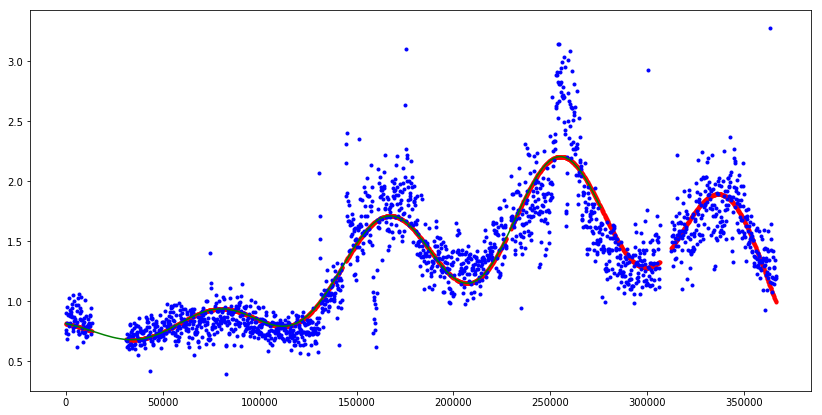

In [22]:
fig = plt.figure(figsize=(14, 7))

plt.plot(TimestampSeaflow_secFromStart_alt, multWaves_func_varPer_4(TimestampSeaflow_secFromStart_alt, *popt_varPer), 'r.')
plt.plot(TimestampSeaflow_secFromStart_alt, dielSeaFlow.trunc['Cbiomass_umol.L'], 'b.')
plt.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_4(
   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_varPer), 'g-')

Plot of the variable-period fit to the Seaflow data

In [ ]:
# get, store current timezone setting
current_matplotTZ = plt.rcParams['timezone']
# set to 'Pacific/Honolulu' temporarily
plt.rcParams['timezone'] = 'Pacific/Honolulu' 

fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(111)
ax1.plot(dielSeaFlow.trunc['Timestamp_ISO8601'],dielSeaFlow.trunc['Cbiomass_umol.L'], 'b.', label = 'SeaFlow biomass (umol/L)')
ax1.xaxis.set_major_locator(pltdates.DayLocator(interval=1))
ax1.xaxis.set_minor_locator(pltdates.HourLocator(byhour=12))
ax1.xaxis.set_major_formatter(pltdates.DateFormatter('%H:%M%\n%b %d %Y')) 
ax1.xaxis.set_minor_formatter(pltdates.DateFormatter('%H:%M')) 
ax1.xaxis_date(pytz.timezone('Pacific/Honolulu'))
plt.ylabel('SeaFlow biomass (umol/L)')

ax2 = ax1.twiny()
#ax2.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_samePer_3(
#   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_samePer), 'g-', label = 'Sinusoidal curve fit with constant period length')
ax2.plot(pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), multWaves_func_varPer_4(
   pandas.Series(list(range(0, int(TimestampSeaflow_secFromStart_alt[len(TimestampSeaflow_secFromStart_alt)-1]), 2000))), *popt_varPer), 'r-', label = 'Sinusoidal curve fit with period length allowed to vary')
plt.xlabel('Time (seconds since experiment start)')

fig.legend(bbox_to_anchor=(.8, .8))

# set matplotlib timezone back
plt.rcParams['timezone'] = current_matplotTZ
